# Exact solution projective rep check
Created 07/10/2024

Objectives:
* Check if the exact solution via SVD yields a projective rep, varying the number of sites used.

# Package imports

In [1]:
import sys
sys.path.append("../..")

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries
from SPTOptimization.Optimizers.utils import one_site_optimization

from SPTOptimization.gradients import expectation_gradient_from_environments_and_b_tensor

In [32]:
from functools import reduce
from itertools import combinations

# Load data

In [9]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [10]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [11]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [12]:
psi_dict = dict()

In [13]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [14]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [15]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [16]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [54]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [17]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [18]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

## Functions

In [203]:
def get_reduced_tensor_matrix(symmetry_case, num_sites, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [160]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [161]:
def get_grouped_site_svd_unitary(symmetry_case, num_sites):
    rdm = get_reduced_tensor_matrix(symmetry_case, num_sites)

    U, S, VH = npc.svd(
        rdm.conj(),
        full_matrices=True,
        inner_labels=['i', 'i*']
    )

    sol = npc.tensordot(U, VH, [['i',], ['i*',]])

    return (sol, S)

In [42]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [44]:
def distance_from_identity(j, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    # Assumes two dimensions

    p1 = grouped_physical_leg_label
    p2 = grouped_physical_leg_conj_label
    e1 = npc.tensordot(j, j.conj(), [[p1, p2], [p2, p1]])

    e2 = npc.trace(j, p1, p2)

    return e1 - 2*e2.real + dim

In [31]:
def gauge_invariant_phase(u1, u2, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    u = reduce(multiply, [u1, u2, u1.conj(), u2.conj()])

    trace = npc.trace(
        u,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    approx_identity = u/phase
    approx_identity_distance = distance_from_identity(
        approx_identity,
        dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    return phase, approx_identity_distance

In [157]:
def state_gauge_invariant_phase(u1, u2, rdm_tensor, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    t = reduce(multiply, [u1, u2, u1.conj(), u2.conj(), rdm_tensor])

    trace = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    return phase

In [34]:
def get_phase_distance_pairs(solutions, matrix_dim, grouped_physical_leg_label,
                            grouped_physical_leg_conj_label):
    # To-do: Automatically get all info. Should only need cases input argument
    solution_pairs = combinations(solutions, 2)

    out = [
        gauge_invariant_phase(
            *p,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in solution_pairs
    ]

    return out

In [162]:
def get_state_phases(solutions, rdm_tensor, matrix_dim,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label):
    # To-do: Automatically get all info. Should only need cases input argument
    solution_pairs = combinations(solutions, 2)

    out = [
        state_gauge_invariant_phase(
            *p,
            rdm_tensor,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in solution_pairs
    ]

    return out

# Calculate solutions

In [204]:
solutions = list()
scores = list()
singular_values = list()

for i in range(1, 7):
    print(i)
    solutions.append(list())
    scores.append(list())
    singular_values.append(list())

    for l in cases:
        solutions[-1].append(list())
        scores[-1].append(list())
        singular_values[-1].append(list())

        for c in l:
            sol, S = get_grouped_site_svd_unitary(c, i)
            
            solutions[-1][-1].append(sol)
            singular_values[-1][-1].append(S)
            scores[-1][-1].append(score)

1
2
3
4
5
6


## Calculate SPT phases and distances

In [225]:
phase_distance_pairs = list()
state_phases = list()

for i, n in enumerate(range(1, 7)):
    phase_distance_pairs.append(list())
    state_phases.append(list())

    matrix_dim = 2**n

    labels = get_grouped_leg_labels(n)
    leg_label, conj_leg_label = labels

    for l, c in zip(solutions[i], cases):
        pair_data = get_phase_distance_pairs(
            l,
            matrix_dim,
            leg_label,
            conj_leg_label
        )

        phase_distance_pairs[-1].append(pair_data)

        rdm = get_reduced_tensor_matrix(c[0], n, normalise=True)

        state_data = get_state_phases(
            l,
            rdm,
            matrix_dim,
            leg_label,
            conj_leg_label
        )

        state_phases[-1].append(state_data)

# Analysis

## Number of sites

### One site

In [226]:
n=0

In [227]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [228]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [229]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [230]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


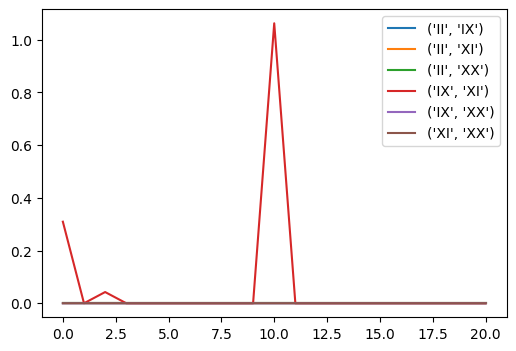

In [231]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

### Two sites

In [234]:
n=1

In [235]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [236]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [237]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [238]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


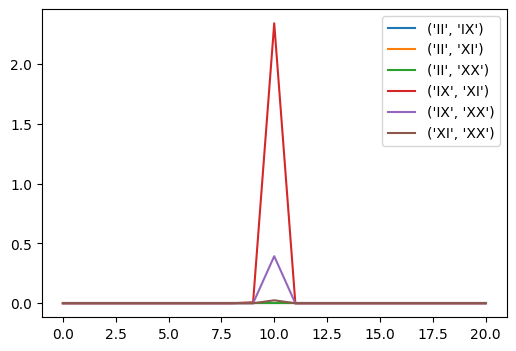

In [239]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

### Three sites

In [240]:
n=2

In [241]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [242]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [243]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [244]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


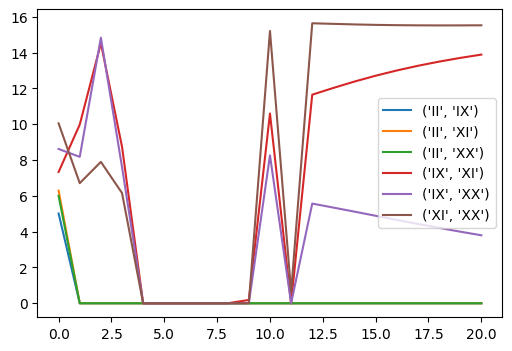

In [245]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

### Four sites

In [246]:
n=3

In [247]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [248]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [249]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [250]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


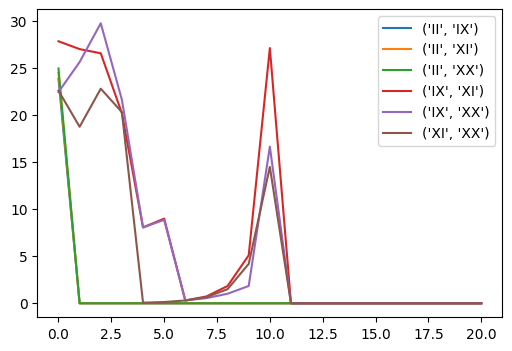

In [251]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

### Five sites

In [252]:
n=4

In [253]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [254]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [255]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [256]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


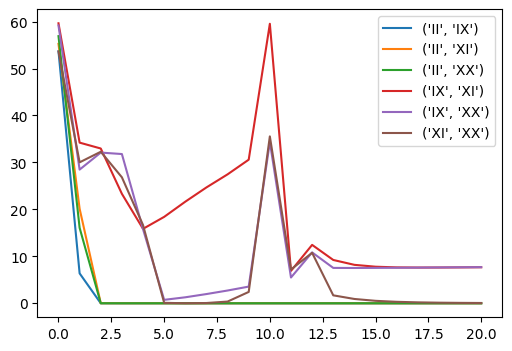

In [257]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

### Six sites

In [258]:
n=5

In [259]:
phases = [[p[0] for p in l] for l in phase_distance_pairs[n]]
distances = [[p[1] for p in l] for l in phase_distance_pairs[n]]

In [260]:
np.round(np.array(phases), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [261]:
np.round(np.array(state_phases[n]), 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [262]:
distances_array = np.real(np.array(distances).T)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_76975/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


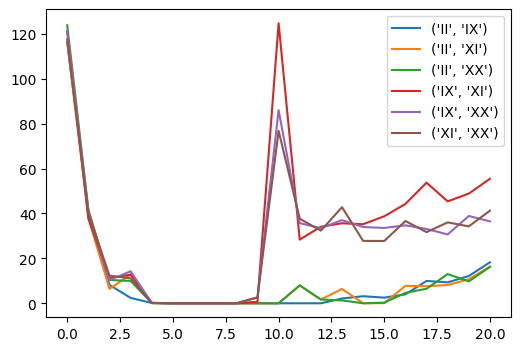

In [263]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

## B=0
Why does the projective rep property change?

In [145]:
b0_solutions = [l1[0]for l1 in solutions]

In [146]:
b0_singular_values = [l1[0]for l1 in singular_values]

In [147]:
b0_scores = np.array([l1[0] for l1 in scores])

In [142]:
b0_scores

array([[1.41421356e+00, 1.41421356e+00, 4.12167598e-14, 4.04121569e-14],
       [1.41421356e+00, 1.41421356e+00, 1.41421356e+00, 1.41421356e+00],
       [1.41421356e+00, 1.41421356e+00, 1.41421356e+00, 1.41421356e+00],
       [1.41421356e+00, 1.41421356e+00, 1.41421356e+00, 1.41421356e+00],
       [1.41421356e+00, 1.41421356e+00, 1.41421356e+00, 1.41421356e+00],
       [1.41421356e+00, 1.41421356e+00, 1.41421356e+00, 1.41421356e+00]])

Scores are pretty flat.

Singular values:

In [153]:
np.round(np.array(b0_singular_values[0]), 3)

array([[0.707, 0.707],
       [0.707, 0.707],
       [0.   , 0.   ],
       [0.   , 0.   ]])

In [154]:
np.round(np.array(b0_singular_values[1]), 3)

array([[0.354, 0.354, 0.354, 0.354],
       [0.354, 0.354, 0.354, 0.354],
       [0.354, 0.354, 0.354, 0.354],
       [0.354, 0.354, 0.354, 0.354]])

In [155]:
np.round(np.array(b0_singular_values[2]), 3)

array([[0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   ]])

In [156]:
np.round(np.array(b0_singular_values[3]), 3)

array([[0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.354, 0.354, 0.354, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

Singular values don't change as more sites are added, just more zeroes added. Therefore expect a degeneracy in the solutions.

## Degeneracy with respect to B

In [271]:
def count_zeros(X, num_decimal_places=4):
    return np.count_nonzero(np.round(X, num_decimal_places)==0)

In [285]:
num_sing_val_zeroes = np.array(
    [
        [
            [count_zeros(l3) for l3 in l2]
            for l2 in l1]
        for l1 in singular_values
    ]
)

In [286]:
num_sing_val_zeroes

array([[[ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  2,  2],
        [ 0,  0,  1,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1],
        [ 0,  0,  1,  1]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  1,  1,  1],
        [ 0,  2,  2,  3],
        [ 0,  2,  2,  3],
        [ 0,  2,  2,  3],
        [ 0,  2,  2,  3],
        [ 0,  2,  2,  3],
        [ 

Degeneracy increases across the board for higher number of sites. But some sites do give a projective rep. So the number of vanishing singular values cannot be the only part of the story.

# Conclusions
* The exact solution space can be degenerate.
    * Vanishing singular values of the reduced density matrix are necessary for this. But they don't give a direct count of the degeneracy necessarily.
* One can extract the SPT phase by acting on the ground state (needs more testing).